Summary
====

The data are fit well by a simple linear form with an intercept added. However, we have the knowledge that the system should obey power $P=0$ when temperature $T=0$ and flow $Q=0$. Given that the origin is some 5 times the spread of the data away from the samples. It is unreasonable to expect to extrapolate back to the origin with the information that we have and no model or physical intuition.

However, inspecting the residuals of the linear fit  indicates a possible quadratic effect suggesting that models of the form
$$ P \sim T + Q^2$$
or
$$ P \sim T + Q + Q^2$$ 
may be appropriate and satisfy the origin condition. These models do not make a significant difference in the residuals however.

We should probably look at AIC / BIC to choose between the models. (However, robust method means some modification is needed https://www.researchgate.net/profile/Elvezio_Ronchetti/publication/23632931_Robust_model_selection_in_regression/links/0deec52cbb5420f128000000.pdf


Import Modules
---

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import statsmodels.api as sm
import numpy as np
import scipy.stats
from sklearn import preprocessing
py.init_notebook_mode()
%matplotlib inline

Load the data and plot
------------

In [4]:
df = pd.read_csv('./data/Dataset.csv').dropna(axis=1,how='all')
df = df.apply(lambda x:x/np.max(x)) #Scale by max only as we care about the origin
print(df.columns)

Index([u'Power', u'Flow', u'Temperature'], dtype='object')


Plotly utils

In [5]:
def plot_scatter(x,y,z):
    data = [go.Scatter3d(
    z=z,
    y=y,
    x=x,
    mode='markers',
    marker=dict(
        size=2,
       
        opacity=0.8
        )
    )]
        
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    
    
def plot_scatter2(x,y):
    data = [go.Scatter(
    y=y,
    x=x,
    mode='markers',
    marker=dict(
        size=2,
       
        opacity=0.8
        )
    )]
        
    layout = go.Layout(
       
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

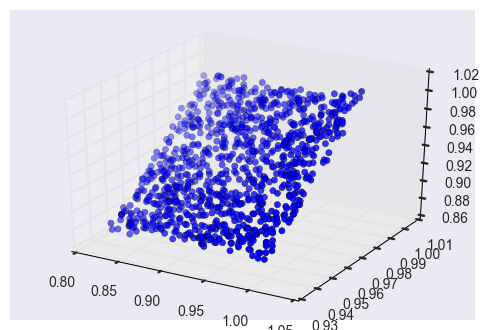

In [6]:
#plt.scatter(df['Temperature'],df['Flow'],df['Power'])
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['Temperature'],df['Flow'],df['Power'])

This looks like a linear process - we'll do a regression and see what the residuals look like

In [7]:
in_data = df[['Temperature','Flow']]
in_data = sm.add_constant(in_data) #This should be 0 according to email

huber_t = sm.RLM(df['Power'],in_data, M=sm.robust.norms.HuberT())
results = huber_t.fit()

In [9]:
def weighted_r_squared(results):
    weights = results.weights
    residuals = results.resid
    fitted = results.fittedvalues
    SSe = np.sum((weights*residuals)**2)
    observed = residuals + fitted
    SSt = np.sum((weights*observed-np.mean(weights*observed))**2)
    return 1- SSe/SSt
    

In [33]:
print(results.params)
print(results.bse)
print(results.summary(yname='y',
            xname=['var_%d' % i for i in range(len(results.params))]))

print('weighted R2 = {v:f}'.format(v=weighted_r_squared(results)))

const         -0.928107
Temperature    0.018772
Flow           1.901343
dtype: float64
const          0.005572
Temperature    0.001863
Flow           0.005533
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 1000
Model:                            RLM   Df Residuals:                      997
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 20 Apr 2017                                         
Time:                        17:10:32                                         
No. Iterations:                    18                                         
                 coef    std err    

In [11]:
residual = df['Power'] - results.predict()

gated_residual = pd.Series(residual)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(gated_residual)


In [12]:
#plot_scatter2(df['Flow'],residual)
#plot_scatter(df['Temperature'],df['Flow'],residual)

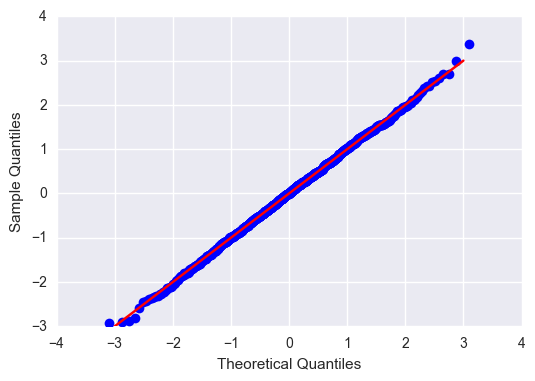

In [13]:
import statsmodels.graphics.gofplots
statsmodels.graphics.gofplots.qqplot(np_scaled)
plt.plot([-3,3],[-3,3],'r-')

Fat tail maybe - also maybe something small for low temp giving some indication of shape to account for origin correction

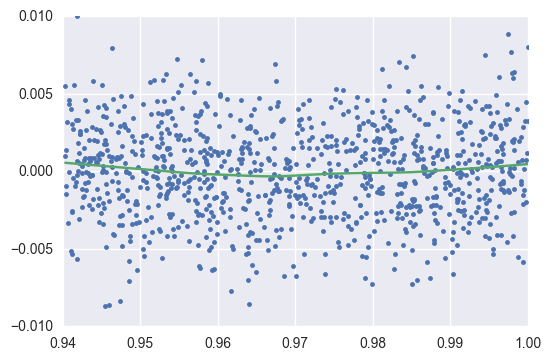

In [14]:
loess_field = 'Flow'
loess = statsmodels.nonparametric.smoothers_lowess.lowess(residual,df[loess_field],frac=0.5).T
plt.plot(df[loess_field],residual,'.')
plt.plot(loess[0],loess[1],'-')


The Durbin-Watson statistic is: 1.961086. Values near to 2 indicate small autocorrelation


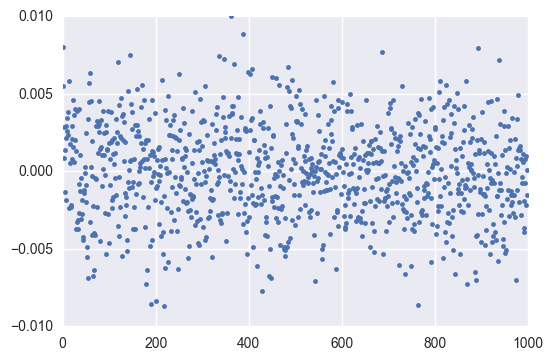

In [22]:
plt.plot(residual,'.')
dw = statsmodels.stats.stattools.durbin_watson(residual, axis=0)
print "The Durbin-Watson statistic is: {v:f}. Values near to 2 indicate small autocorrelation".format(v=dw)

Test the residuals for normality with Kolmogorov-Smirnov

In [23]:
scipy.stats.kstest(np_scaled,'norm')

KstestResult(statistic=0.012214080438941011, pvalue=0.99833751825809336)

There is a small deviation at each end with a quadratic nature. We can try adding a term quadratic in Flow and removing constant term.

$$ P = \alpha T + \beta Q + \gamma Q^2 $$

In [17]:
quad_data = pd.DataFrame([df['Temperature'],df['Flow']**2]).T
quad_model = sm.RLM(df['Power'],quad_data, M=sm.robust.norms.HuberT())
quad_results = quad_model.fit()
print(quad_results.params)
print(quad_results.bse)
print(quad_results.summary(yname='y',
            xname=['var_%d' % i for i in range(len(quad_results.params))]))
print('weighted R2 = {v:f}'.format(v=weighted_r_squared(quad_results)))

Temperature    0.016817
Flow           0.975316
dtype: float64
Temperature    0.001591
Flow           0.001540
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 1000
Model:                            RLM   Df Residuals:                      998
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 20 Apr 2017                                         
Time:                        12:08:09                                         
No. Iterations:                    16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

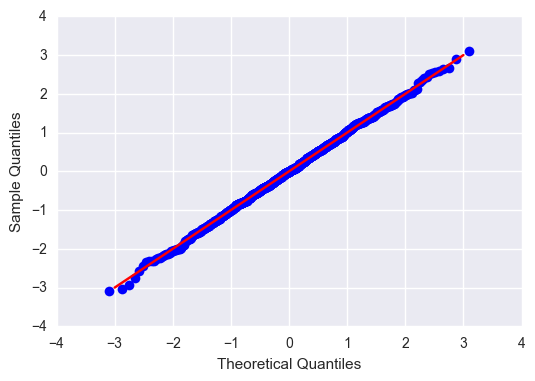

In [18]:
quad_residual = df['Power']-quad_results.predict()
quad_residual_scaled = min_max_scaler.fit_transform(quad_residual)

statsmodels.graphics.gofplots.qqplot(quad_residual_scaled)
#plot_scatter(df['Temperature'],df['Flow'],quad_residual_scaled)
plt.plot([-3,3],[-3,3],'r-')

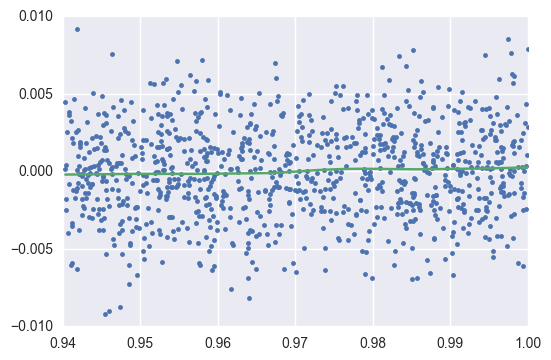

In [19]:
loess_field = 'Flow'
quad_loess = statsmodels.nonparametric.smoothers_lowess.lowess(quad_residual,df[loess_field],frac=0.5).T
plt.plot(df[loess_field],quad_residual,'.')
plt.plot(quad_loess[0],quad_loess[1],'-')

Main point - given how far the flow data is away from the origin, the precise nature of the behaviour near the origin should be guided by physical principles if no other data is available. We can add arbitrary functional forms to achieve the requirement that $P = 0$ when $Q = 0$ and $T = 0$ such that the almost linear character of the function in the region that we are given data is preserved.

There does not appear to be much difference between the two cases $P \sim Q + Q^2 +T$ or $P \sim Q^2 + T$

Any time series stuff we can do to clean the data? (Doesn't look like it)

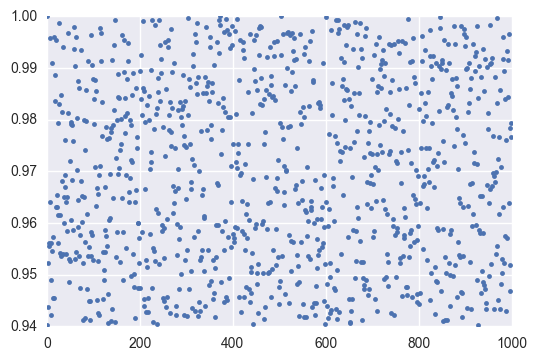

In [24]:
plt.plot(df['Flow'],'.')

Is there any dependence on how noisy the readings are given the input variables (i.e. heteroskedacity)
---------

Not entirely necessary to do the robust fitting

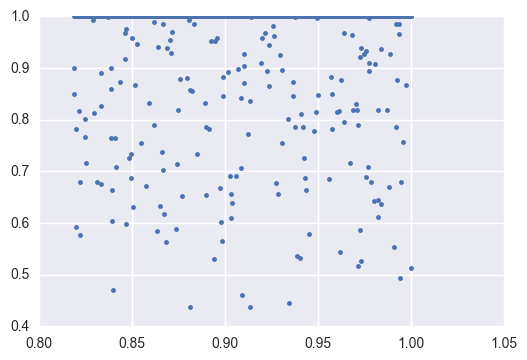

In [67]:
plt.plot(df['Temperature'],quad_results.weights,'.')

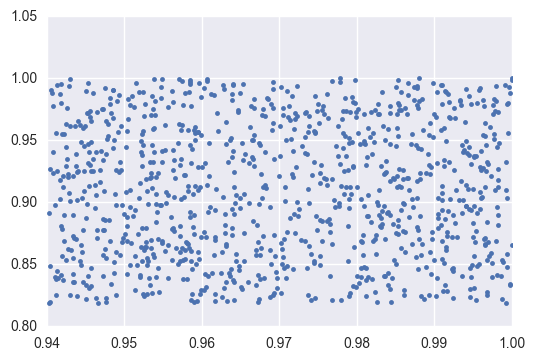

In [69]:
plt.plot(df['Flow'],df['Temperature'],'.')

Quick ANOVA for the two models to see if they are significantly different over the range of the data (No, they are not)

In [29]:
f_val, p_val = scipy.stats.f_oneway(residual, quad_residual)
print f_val, p_val

0.00123622741094 0.971955649498
